In [1]:
import pandas as pd
import numpy as np
!pip install yfinance
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("Solarize_Light2")

In [2]:
asset_list = ["amzn", "aapl", "fb", "googl","ibm"]
tickers = yf.download( tickers = asset_list, period = "10y")
tickers=tickers["Adj Close"]

[*********************100%***********************]  5 of 5 completed


In [3]:
# Normalizing data
return_log=np.log(tickers/tickers.shift(1))

In [4]:
#generating a set of random portfolios, and calculating return & volatility & sharpe ratio
num_portfolios = 5000
all_weights = np.zeros((num_portfolios, len(tickers.columns)))
return_list = np.array([])
volatility_list = np.array([])
sharpe_list = np.array([])

for x in range(num_portfolios):
    weights = np.array(np.random.random(len(tickers.columns)))
    weights = weights/np.sum(weights)
    all_weights[x,:] = weights
    
    return_list= np.append(return_list, np.sum( (return_log.mean() * weights * 252))) # 252 trading days per year on average
    
    volatility_list= np.append(volatility_list, np.sqrt(np.dot(weights.T, np.dot(return_log.cov()*252, weights))))
    
    sharpe_list= np.append(sharpe_list, return_list[x]/volatility_list[x])

In [5]:
# The maximum sharpe ratio found:
print("max Sharpe ratio :",sharpe_list.max(), "\n located at index :", sharpe_list.argmax())
print("weights : ",all_weights[sharpe_list.argmax(),:])
max_return, max_volatility = return_list[sharpe_list.argmax()],volatility_list[sharpe_list.argmax()]

max Sharpe ratio : 1.0816748838022867 
 located at index : 370
weights :  [3.65538069e-01 3.64879110e-01 3.99307090e-02 2.29567722e-01
 8.43906082e-05]


In [6]:
# get infos from weights :
def get_return_and_volatility(weights):
    weights = np.array(weights)
    _return_ = np.sum(return_log.mean() * weights) * 252
    _volatility_ = np.sqrt(np.dot(weights.T, np.dot(return_log.cov()*252, weights)))
    _sharpe_ = _return_/_volatility_
    return {"return":_return_, "volatility":_volatility_,"sharpe_ratio":_sharpe_}

constraints={"type":"eq","fun":(lambda weights: np.sum(weights)-1)} #checksum function
bounds= np.ones((len(tickers.columns), 2))*(0,1)
initial_guess= np.linspace(1,1,(len(tickers.columns)))*(1/len(tickers.columns))

In [7]:
from scipy.optimize import minimize,optimize

#creating an optimizer to find the highest sharpe ratio, and one to find the lowest volatility
optimize_res=minimize((lambda weights: - get_return_and_volatility(weights)["sharpe_ratio"]), initial_guess, method="SLSQP",bounds=bounds,constraints=constraints)
optimize_min_res= minimize((lambda weights: get_return_and_volatility(weights)["volatility"]), initial_guess, method="SLSQP",bounds=bounds,constraints=constraints)

In [8]:
#extracting infos from optimized weights :

max_sharpe_ratio  = get_return_and_volatility(optimize_res.x)
max_sharpe_ratio["weights"]= optimize_res.x

min_volatility_sharpe_ratio  = get_return_and_volatility(optimize_min_res.x)
min_volatility_sharpe_ratio["weights"]= optimize_min_res.x

### Computing and plotting frontier : 

In [10]:
frontier_y = np.linspace(0,volatility_list.max(),200)

In [11]:
frontier_x = []

for possible_return in frontier_y:
    constraints = ({'type':'eq', 'fun':(lambda weights: np.sum(weights)-1)}, {'type':'eq', 'fun': lambda weights: get_return_and_volatility(weights)["return"] - possible_return})
    result = minimize((lambda weights:get_return_and_volatility(weights)["volatility"] ),initial_guess,method='SLSQP', bounds=bounds, constraints=constraints)
    frontier_x.append(result['fun'])

------------------------------ 
 Maximum Sharpe Ratio Allocation 
        allocation
AAPL     0.359186
AMZN     0.320892
FB       0.063871
GOOGL    0.256051
IBM      0.000000

 return : 0.2549124190385776 
 volatility : 0.23533917188609507
------------------------------ 
 Minimum Volatility Allocation 
        allocation
AAPL     0.144992
AMZN     0.094355
FB       0.056403
GOOGL    0.210760
IBM      0.493490

 return : 0.1327793734494287 
 volatility : 0.19910517467217095


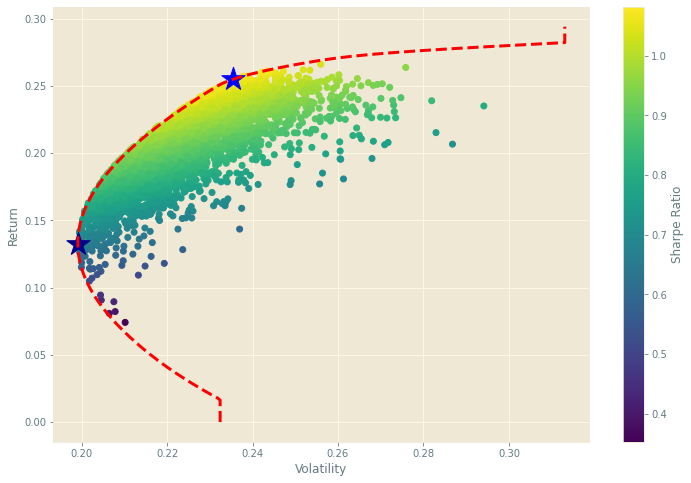

In [18]:
min_volatility_allocation = pd.DataFrame(min_volatility_sharpe_ratio["weights"],index=tickers.columns,columns=['allocation'])
max_sharpe_allocation = pd.DataFrame(max_sharpe_ratio["weights"],index=tickers.columns,columns=['allocation'])

print("-"*30, "\n Maximum Sharpe Ratio Allocation \n", max_sharpe_allocation)
print("\n return :", max_sharpe_ratio["return"], "\n volatility :", max_sharpe_ratio["volatility"] )
print("-"*30, "\n Minimum Volatility Allocation \n", min_volatility_allocation)
print("\n return :", min_volatility_sharpe_ratio["return"], "\n volatility :", min_volatility_sharpe_ratio["volatility"] )

plt.figure(figsize=(12,8))
plt.scatter(volatility_list, return_list, c=sharpe_list, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(max_sharpe_ratio["volatility"], max_sharpe_ratio["return"],c='blue', marker="*", s=600, label='Maximum Sharpe Ratio')
plt.scatter(min_volatility_sharpe_ratio["volatility"], min_volatility_sharpe_ratio["return"],c='darkblue', marker="*", s=600, label='Minimum Volatility')

plt.plot(frontier_x,frontier_y, 'r--', linewidth=3)
plt.show()